# 数値の画像認識モデルの学習

+ ctrl + Enterでセルを実行できます
+ 上から順番にセルを実行することで、画像認識モデルの学習を進めることができます

+ Anacondaでインストールした場合は、KerasとTensorflowのライブラリをインストールする必要があります
+ 下のセルのモードをMarkdownからCodeに変えて実行するとインストールできます

%%bash

pip install --upgrade tensorflow
pip install keras

In [1]:
%matplotlib inline 
import matplotlib.pyplot as plt
import os
import base64
import json
from io import BytesIO
from glob import iglob

import pandas as pd
import numpy as np
from PIL import Image, ImageFile
from skimage import transform as tf
from skimage.color import rgb2gray
from skimage.io import imread
from IPython.display import HTML
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import (
    Dense, Dropout, Activation, Flatten, Conv2D,
    MaxPooling2D, AveragePooling2D, BatchNormalization,
)

pd.set_option('max_colwidth', -1)
ImageFile.LOAD_TRUNCATED_IMAGES = True

Using TensorFlow backend.


In [2]:
def resize(img_array, size=400):
    h, w, c = img_array.shape
    padding_h = int((h-size) / 2)
    padding_w = int((w-size) / 2)
    return img_array[padding_h:padding_h + size, padding_w: padding_w + size]

# labels_for_400 = [1,2,2,0,3,2,2,2,0,3,2,3,1,1,1,2,3,2,3,3,3,0,0,1,3,3,3,1,3,3,3,0,1]

def generate_data():
    for filepath, label in zip(iglob('./image/*'), labels_for_400):
        img = resize(imread(filepath))
        yield (rgb2gray(tf.resize(img, (64, 64), mode='reflect')), label)

def gen_data():
    df = pd.DataFrame(generate_data())
    df.columns = ['x', 'y']
    test_data_df = df.groupby('y').head(2)
    train_data_df = df[~df.index.isin(test_data_df.index)]
    return np.expand_dims(np.stack(train_data_df.x), -1), np.stack(train_data_df.y), \
                np.expand_dims(np.stack(test_data_df.x), -1), np.stack(test_data_df.y)

In [3]:
img_tag_template = '<img src="data:image/png;base64,{}" />'
label_map = {
    0: '不明',
    1: '1',
    2: '2',    
    3: '3',
}
def to_base_64(image_array):
    image = Image.fromarray((image_array * 255).astype(np.uint8))
    output = BytesIO()
    image.save(output, format='PNG')
    return base64.b64encode(output.getvalue()).decode()

def iter_data(generator):
    df = pd.DataFrame(generator)
    df.columns = ['x', 'y']
    return pd.DataFrame({
        'image': df.x.apply(to_base_64).apply(lambda x: img_tag_template.format(x)),
        'label': df.y.map(label_map),
    })

def iter_result(model):
    df = pd.DataFrame(generate_data())
    df.columns = ['x', 'y']
    y_pred = model.predict(np.expand_dims(np.stack(df.x), -1))
    return pd.DataFrame({
        'image': df.x.apply(to_base_64).apply(lambda x: img_tag_template.format(x)),
        'label': df.y.map(label_map),
        'prediction': pd.Series(np.argmax(y_pred, axis=1)).map(label_map)
    })


# まずは画像に正解のラベルをつけましょう

+ 下のセルを実行すると、画像の一覧が表示されます(画像をダブルクリックすると大きく表示されます)
+ 表示された画像は、imageディレクトリにある画像を64 x 64のサイズに変換した後、順番に表示しています
+ 数字を順番にlabel_listの中に入力しましょう

,,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32
label,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
不明,image,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,

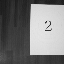
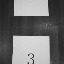
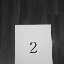
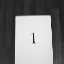
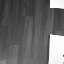
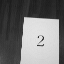
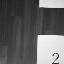
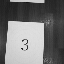
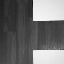
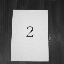
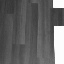
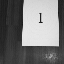
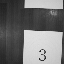
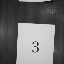
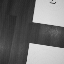
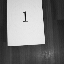
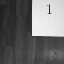
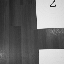
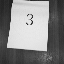
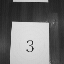
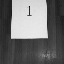
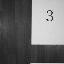
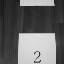
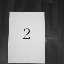
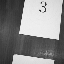
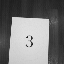
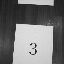
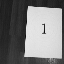
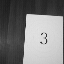
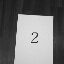
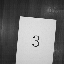
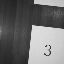
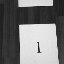

In [4]:
def generate_data():
    for filepath in iglob('./image/*'):
        img = resize(imread(filepath))
        yield (rgb2gray(tf.resize(img, (64, 64), mode='reflect')), 0)
tmp_df = iter_data(generate_data()).groupby('label').apply(lambda df: df.reset_index()[['image']].transpose())
HTML(tmp_df.to_html(escape=False))

In [5]:
labels_list = [2,3,2,1,0,2,2,3,0,2,0,1,3,3,0,1,1,0,3,3,1,3,2,2,3,3,3,1,3,2,3,3,1]

# ラベルを確認しましょう

+ 下のセルを実行すると、ラベルごとに分類された状態で画像が表示されます
+ ラベルのつけ間違いをしていないかを確認しましょう

,,0,1,2,3,4,5,6,7,8,9,10,11,12
label,,,,,,,,,,,,,,
1,image,,,,,,,,NaN,NaN,NaN,NaN,NaN,NaN
2,image,,,,,,,,,NaN,NaN,NaN,NaN,NaN
3,image,,,,,,,,,,,,,
不明,image,,,,,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN

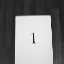
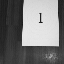
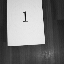
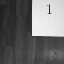
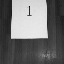
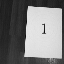
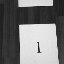
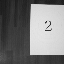
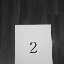
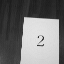
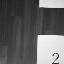
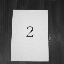
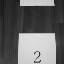
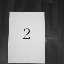
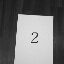
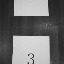
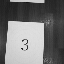
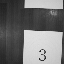
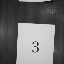
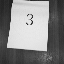
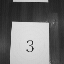
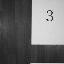
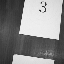
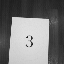
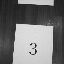
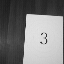
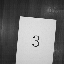
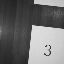
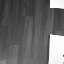
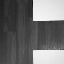
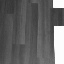
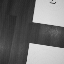
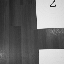

In [6]:
def generate_data():
    for filepath, label in zip(iglob('./image/*'), labels_list):
        img = resize(imread(filepath))
        yield (rgb2gray(tf.resize(img, (64, 64), mode='reflect')), label)
tmp_df = iter_data(generate_data()).groupby('label').apply(lambda df: df.reset_index()[['image']].transpose())
HTML(tmp_df.to_html(escape=False))

# モデルの学習の時のパラメータを決めましょう

+ batch_size: バッチサイズ。大きいほど学習の精度が上がりますが、CPUで処理する場合、学習に時間がかかるようになります。(GPUの場合は学習が終わるのが早くなります)
+ num_classes: 分類するクラスの数です。基本、変更しません。[1, 2, 3, 不明]の4つのクラスに分類しています
+ epochs: 学習データを何回学習に使用するか？の数です。大きいほど、学習に時間がかかりますが、精度が上がります。
+ learning_rate: 学習率。学習が収束する速度や、精度に影響します

In [7]:
batch_size = 32
num_classes = 4
epochs = 10
learning_rate = 0.0001

In [8]:
data_augmentation = True
save_dir = os.path.join(os.getcwd(), 'saved_models')
model_name = 'model.h5'

x_train, y_train, x_test, y_test = gen_data()
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

print('学習データの形[データ数, 横, 縦, チャネル]: ', x_train.shape)
print('学習データのラベルの形[データ数, クラス数]', y_train.shape)
print('テストデータの形[データ数, 横, 縦, チャネル]: ', x_test.shape)
print('テストデータのラベルの形[データ数, クラス数]', y_test.shape)

学習データの形[データ数, 横, 縦, チャネル]:  (25, 64, 64, 1)
学習データのラベルの形[データ数, クラス数] (25, 4)
テストデータの形[データ数, 横, 縦, チャネル]:  (8, 64, 64, 1)
テストデータのラベルの形[データ数, クラス数] (8, 4)


# 学習モデルを確認しましょう

+ 下のセルを実行すると、ニューラルネットワークのモデルの内容を確認することができます
+ Total Paramsの数が小さいほど、学習や予測が早くなりますが、精度が落ちる可能性があります

In [9]:
model = Sequential()
model.add(Conv2D(16, (3, 3), padding='same',
                 input_shape=x_train.shape[1:]))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(16, (3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())
model.add(Conv2D(16, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(num_classes, (1, 1)))
model.add(Activation('relu'))
model.add(AveragePooling2D(pool_size=(16, 16)))
model.add(Flatten())
model.add(Activation('softmax'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 64, 64, 16)        160       
_________________________________________________________________
batch_normalization_1 (Batch (None, 64, 64, 16)        64        
_________________________________________________________________
activation_1 (Activation)    (None, 64, 64, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 16)        2320      
_________________________________________________________________
batch_normalization_2 (Batch (None, 64, 64, 16)        64        
_________________________________________________________________
activation_2 (Activation)    (None, 64, 64, 16)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 16)        0         
__________

# 学習を行う

+ 下のセルを実行すると、学習が始まります
+ 各エポックごとに、学習の様子が表示されます
    + loss: 学習データでモデルを評価した時の損失 -> 小さい方が良い
    + acc: 学習データでモデルを評価した時の精度 -> 大きい方が良い
    + val_loss: テストデータでモデルを評価した時の損失 -> 小さい方が良い
    + val_acc: テストデータでモデルを評価した時の精度 -> 大きい方が良い
+ 学習が終わると、saved_modelsというディレクトリの下に、model.h5という名前でモデルファイルが保存されます

In [10]:
# initiate RMSprop optimizer
opt = keras.optimizers.rmsprop(lr=learning_rate, decay=1e-6)

# Let's train the model using RMSprop
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

if not data_augmentation:
    print('Not using data augmentation.')
    history = model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              validation_data=(x_test, y_test),
              shuffle=True)
else:
    print('Using real-time data augmentation.')
    # This will do preprocessing and realtime data augmentation:
    datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        zoom_range=[0.9, 1.1],
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images

    # Compute quantities required for feature-wise normalization
    # (std, mean, and principal components if ZCA whitening is applied).
    datagen.fit(x_train)

    # Fit the model on the batches generated by datagen.flow().
    history = model.fit_generator(datagen.flow(x_train, y_train,
                                     batch_size=batch_size),
                        epochs=epochs,
                        validation_data=(x_test, y_test),
                        workers=4,
                        steps_per_epoch=100
                       )

# Save model and weights
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)
model.save(model_path)

# Score trained model.
scores = model.evaluate(x_test, y_test, verbose=1)
print('テストデータの損失値(0に近いほど良い):', scores[0])
print('テストデータの精度(1に近いほど良い):', scores[1])

Using real-time data augmentation.
Epoch 1/10
100/100 [==============================] - 61s 612ms/step - loss: 1.3671 - acc: 0.2656 - val_loss: 1.3934 - val_acc: 0.2500
Epoch 2/10
100/100 [==============================] - 56s 562ms/step - loss: 1.2343 - acc: 0.4488 - val_loss: 1.4312 - val_acc: 0.2500
Epoch 3/10
100/100 [==============================] - 58s 581ms/step - loss: 1.1459 - acc: 0.5320 - val_loss: 1.5223 - val_acc: 0.2500
Epoch 4/10
100/100 [==============================] - 57s 575ms/step - loss: 1.0430 - acc: 0.6184 - val_loss: 1.6028 - val_acc: 0.2500
Epoch 5/10
100/100 [==============================] - 58s 579ms/step - loss: 0.9541 - acc: 0.6664 - val_loss: 1.2863 - val_acc: 0.5000
Epoch 6/10
100/100 [==============================] - 57s 574ms/step - loss: 0.8800 - acc: 0.7056 - val_loss: 0.9288 - val_acc: 0.6250
Epoch 7/10
100/100 [==============================] - 51s 505ms/step - loss: 0.8206 - acc: 0.7216 - val_loss: 0.7217 - val_acc: 0.7500
Epoch 8/10
100/100 [

### エポックごとに損失値がどのように変化したか

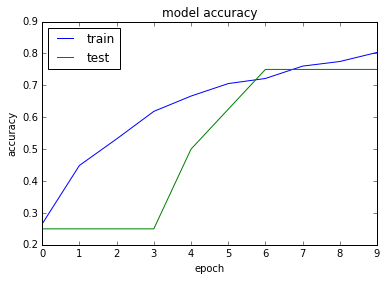

In [11]:
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

### エポックごとに精度がどのように変化したか

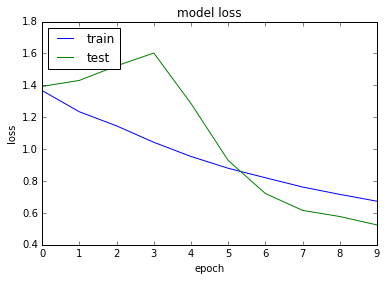

In [12]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# テストデータのラベルと予測値を比較して結果を確認する

,画像,ラベル,モデルによる予測値
0,,2,3
1,,3,3
2,,2,2
3,,1,1
4,,不明,不明
5,,3,3
6,,不明,3
7,,1,1

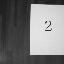
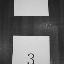
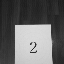
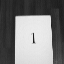
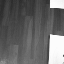
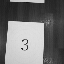
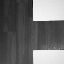
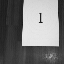

In [13]:
# result_df = iter_result(model)
y_pred = model.predict(x_test)
result_df = pd.DataFrame({
    '画像': pd.Series([d[:,:,0] for d in x_test]).apply(to_base_64).apply(lambda x: img_tag_template.format(x)),
    'ラベル': pd.Series(np.argmax(y_test, axis=1)).map(label_map),
    'モデルによる予測値': pd.Series(np.argmax(y_pred, axis=1)).map(label_map)
})
HTML(result_df[['画像', 'ラベル', 'モデルによる予測値']].to_html(escape=False))